In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# --- Load and preprocess data ---
df = pd.read_csv("D:\PROGRAMMING\PROJECTS\PYTHON\TF\RESEARCH\RESEARCH\DATA\datafe.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

# Smooth the CGM values (optional, helps remove spikes)
df['CGM (mg / dl)'] = df['CGM (mg / dl)'].rolling(window=3, min_periods=1).mean()

# Drop rows with missing CGM values
df = df.dropna(subset=['CGM (mg / dl)'])

# Extract time-based features
df['hour'] = df['Date'].dt.hour
df['minute'] = df['Date'].dt.minute
df['dayofweek'] = df['Date'].dt.dayofweek

# Standard scaling
scaler_cgm = StandardScaler()
df['CGM_scaled'] = scaler_cgm.fit_transform(df[['CGM (mg / dl)']])

scaler_time = StandardScaler()
df[['hour_scaled', 'minute_scaled', 'dayofweek_scaled']] = scaler_time.fit_transform(df[['hour', 'minute', 'dayofweek']])

# --- Prepare sequences ---
time_steps = 8  # past 2 hours if 15-min interval
future_steps = [1, 4, 8]  # 15, 60, 120 min ahead

features = ['CGM_scaled', 'hour_scaled', 'minute_scaled', 'dayofweek_scaled']

X, y = [], []

for i in range(len(df) - time_steps - max(future_steps)):
    x_seq = df[features].iloc[i:i+time_steps].values
    y_seq = [df['CGM_scaled'].iloc[i + time_steps + offset - 1] for offset in future_steps]
    X.append(x_seq)
    y.append(y_seq)

X = np.array(X)
y = np.array(y)

# --- Split train and test ---
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# --- Build enhanced Bidirectional LSTM model ---
model = Sequential([
    Bidirectional(LSTM(128, return_sequences=True), input_shape=(time_steps, X.shape[2])),
    Dropout(0.3),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(32)),
    Dropout(0.2),
    Dense(3)  # outputs: 15, 60, 120 min ahead
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

# --- Callbacks ---
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint("best_model.keras", monitor="val_loss", save_best_only=True)
]

# --- Train the model ---
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

<>:13: SyntaxWarning: invalid escape sequence '\P'
<>:13: SyntaxWarning: invalid escape sequence '\P'
C:\Users\SANJAY\AppData\Local\Temp\ipykernel_27768\2761862207.py:13: SyntaxWarning: invalid escape sequence '\P'
  df = pd.read_csv("D:\PROGRAMMING\PROJECTS\PYTHON\TF\RESEARCH\RESEARCH\DATA\datafe.csv")
C:\Users\SANJAY\AppData\Local\Temp\ipykernel_27768\2761862207.py:13: DtypeWarning: Columns (8,9,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("D:\PROGRAMMING\PROJECTS\PYTHON\TF\RESEARCH\RESEARCH\DATA\datafe.csv")
d:\PROGRAMMING\PROJECTS\PYTHON\TF\RESEARCH\.venv\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 8, 256)         │       136,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 8, 128)         │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 341,955 (1.30 MB)

 Trainable params: 341,955 (1.30 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
2246/2246 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - loss: 0.3752 - mae: 0.4445 - val_loss: 0.2671 - val_mae: 0.3899
Epoch 2/10
2246/2246 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - loss: 0.2828 - mae: 0.3864 - val_loss: 0.2157 - val_mae: 0.3502
Epoch 3/10
2246/2246 ━━━━━━━━━━━━━━━━━━━━ 28s 13ms/step - loss: 0.2359 - mae: 0.3501 - val_loss: 0.1785 - val_mae: 0.3141
Epoch 4/10
2246/2246 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - loss: 0.2119 - mae: 0.3298 - val_loss: 0.1801 - val_mae: 0.3135
Epoch 5/10
2246/2246 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - loss: 0.2008 - mae: 0.3205 - val_loss: 0.1695 - val_mae: 0.3049
Epoch 6/10
2246/2246 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - loss: 0.1962 - mae: 0.3150 - val_loss: 0.1618 - val_mae: 0.2907
Epoch 7/10
2246/2246 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 0.1865 - mae: 0.3070 - val_loss: 0.1644 - val_mae: 0.2979
Epoch 8/10
2246/2246 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - loss: 0.1788 - mae: 0.3003 - val_loss: 0.1604 - val_mae: 0.2917
Epoch 9/10
2246/2246 ━━━━━━━━━

702/702 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
15 min Prediction -> RMSE: 8.92, MAE: 6.10
60 min Prediction -> RMSE: 16.26, MAE: 10.29
120 min Prediction -> RMSE: 25.48, MAE: 16.35


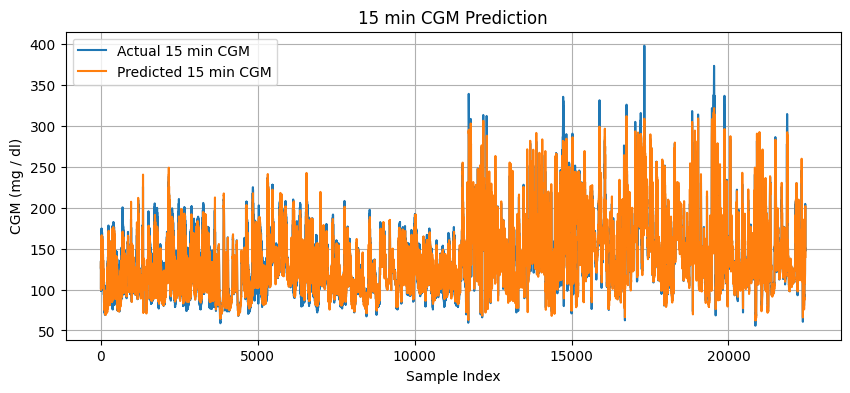

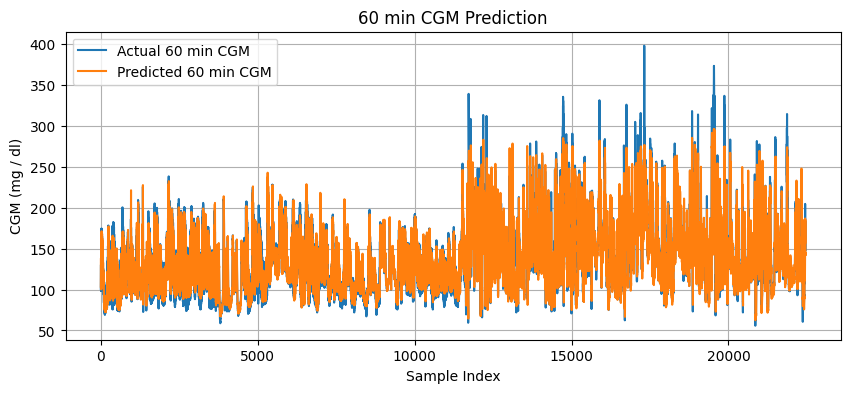

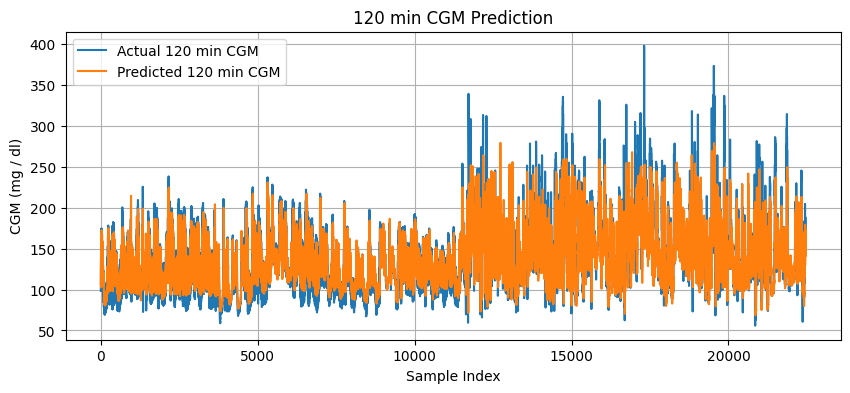

In [2]:
# --- Predict ---
y_pred = model.predict(X_test)

# Inverse transform only CGM values (not time features)
y_pred_inv = scaler_cgm.inverse_transform(y_pred)
y_test_inv = scaler_cgm.inverse_transform(y_test)

# --- Evaluation ---
time_labels = ['15 min', '60 min', '120 min']

for i, label in enumerate(time_labels):
    rmse = np.sqrt(mean_squared_error(y_test_inv[:, i], y_pred_inv[:, i]))
    mae = mean_absolute_error(y_test_inv[:, i], y_pred_inv[:, i])
    print(f"{label} Prediction -> RMSE: {rmse:.2f}, MAE: {mae:.2f}")

# --- Plot predictions ---
for i in range(3):
    plt.figure(figsize=(10, 4))
    plt.plot(y_test_inv[:, i], label=f"Actual {time_labels[i]} CGM")
    plt.plot(y_pred_inv[:, i], label=f"Predicted {time_labels[i]} CGM")
    plt.title(f"{time_labels[i]} CGM Prediction")
    plt.xlabel("Sample Index")
    plt.ylabel("CGM (mg / dl)")
    plt.legend()
    plt.grid(True)
    plt.show()